In [ ]:
!pip install do_mpc
!sudo apt install imagemagick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk popp

In [1]:
import numpy as np
import do_mpc
#from math import *
from casadi import *

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [3]:
q1 = model.set_variable(var_type='_x', var_name='q1', shape=(1,1))
q2 = model.set_variable(var_type='_x', var_name='q2', shape=(1,1))
q3 = model.set_variable(var_type='_x', var_name='q3', shape=(1,1))
dq = model.set_variable(var_type='_x', var_name='dq', shape=(3,1))

# Three inputs for the torque:
u1 = model.set_variable(var_type='_u', var_name='u1')
u2 = model.set_variable(var_type='_u', var_name='u2')
u3 = model.set_variable(var_type='_u', var_name='u3')

#q_des1 = model.set_variable(var_type='_u', var_name='q_des1', shape=(1,1))
#q_des2 = model.set_variable(var_type='_u', var_name='q_des2', shape=(1,1))
#q_des3 = model.set_variable(var_type='_u', var_name='q_des3', shape=(1,1))

# Two additional states for the true motor position:
#q_1_m = model.set_variable(var_type='_x', var_name='q_1_m', shape=(1,1))
#q_2_m = model.set_variable(var_type='_x', var_name='q_2_m', shape=(1,1))

m3 = model.set_variable('parameter', 'm3')
dc3 = model.set_variable('parameter', 'dc3')
I3zz = model.set_variable('parameter', 'I3zz')

In [4]:
from numpy.matrixlib.defmatrix import matrix
# We define the other parameters
m1 = 3
m2 = 3

L1 = 0.5
L2 = 0.5
L3 = 0.5

I1zz = 0.25
I2zz = 0.25

dc1 = 0.25
dc2 = 0.25

g0 = 9.81



"""M = SX([[ I1zz + I2zz + I3zz + (L1**2)*m2 + (L1**2)*m3 + (L2**2)*m3 + dc1**2*m1 + dc2**2*m2 + power(dc3,2)*m3 + 2*L1*dc3*m3*cos(q2 + q3) + 2*L1*L2*m3*cos(q2) + 2*L1*dc2*m2*cos(q2) + 2*L2*dc3*m3*cos(q3), m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + L1*m3*cos(q2)*L2 + m2*dc2**2 + L1*m2*cos(q2)*dc2 + m3*power(dc3,2) + L1*m3*cos(q2 + q3)*dc3 + I2zz + I3zz, I3zz + dc3*m3*(dc3 + L1*cos(q2 + q3) + L2*cos(q3))],
              [                                                 m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + L1*m3*cos(q2)*L2 + m2*dc2**2 + L1*m2*cos(q2)*dc2 + m3*power(dc3,2) + L1*m3*cos(q2 + q3)*dc3 + I2zz + I3zz,                                                                 m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + m2*dc2**2 + m3*power(dc3,2) + I2zz + I3zz,                   I3zz + dc3*m3*(dc3 + L2*cos(q3))],
              [                                                                                                                                         I3zz + dc3*m3*(dc3 + L1*cos(q2 + q3) + L2*cos(q3)),                                                                                                  I3zz + dc3*m3*(dc3 + L2*cos(q3)),                                    m3*power(dc3,2) + I3zz]])

c = np.array([[- L1*dc3*m3*dq[1]**2*sin(q2 + q3) - L1*dc3*m3*dq[2]**2*sin(q2 + q3) - L1*L2*m3*dq[1]**2*sin(q2) - L1*dc2*m2*dq[1]**2*sin(q2) - L2*dc3*m3*dq[2]**2*sin(q3) - 2*L1*dc3*m3*dq[0]*dq[1]*sin(q2 + q3) - 2*L1*dc3*m3*dq[0]*dq[2]*sin(q2 + q3) - 2*L1*dc3*m3*dq[1]*dq[2]*sin(q2 + q3) - 2*L1*L2*m3*dq[0]*dq[1]*sin(q2) - 2*L1*dc2*m2*dq[0]*dq[1]*sin(q2) - 2*L2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*L2*dc3*m3*dq[1]*dq[2]*sin(q3)],
              [                                                                                                                                                                                                                                      L1*dc3*m3*dq[0]**2*sin(q2 + q3) + L1*L2*m3*dq[0]**2*sin(q2) + L1*dc2*m2*dq[0]**2*sin(q2) - L2*dc3*m3*dq[2]**2*sin(q3) - 2*L2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*L2*dc3*m3*dq[1]*dq[2]*sin(q3)],
              [                                                                                                                                                                                                                                                                                                                         dc3*m3*(L1*dq[0]**2*sin(q2 + q3) + L2*dq[0]**2*sin(q3) + L2*dq[1]**2*sin(q3) + 2*L2*dq[0]*dq[1]*sin(q3))]])
 
g = np.array([[g0*m3*(L2*cos(q1 + q2) + L1*cos(q1) + dc3*cos(q1 + q2 + q3)) + g0*m2*(dc2*cos(q1 + q2) + L1*cos(q1)) + dc1*g0*m1*cos(q1)],
              [                                                g0*m3*(L2*cos(q1 + q2) + dc3*cos(q1 + q2 + q3)) + dc2*g0*m2*cos(q1 + q2)],
              [                                                                                             dc3*g0*m3*cos(q1 + q2 + q3)]])

"""


'M = SX([[ I1zz + I2zz + I3zz + (L1**2)*m2 + (L1**2)*m3 + (L2**2)*m3 + dc1**2*m1 + dc2**2*m2 + power(dc3,2)*m3 + 2*L1*dc3*m3*cos(q2 + q3) + 2*L1*L2*m3*cos(q2) + 2*L1*dc2*m2*cos(q2) + 2*L2*dc3*m3*cos(q3), m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + L1*m3*cos(q2)*L2 + m2*dc2**2 + L1*m2*cos(q2)*dc2 + m3*power(dc3,2) + L1*m3*cos(q2 + q3)*dc3 + I2zz + I3zz, I3zz + dc3*m3*(dc3 + L1*cos(q2 + q3) + L2*cos(q3))],\n              [                                                 m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + L1*m3*cos(q2)*L2 + m2*dc2**2 + L1*m2*cos(q2)*dc2 + m3*power(dc3,2) + L1*m3*cos(q2 + q3)*dc3 + I2zz + I3zz,                                                                 m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + m2*dc2**2 + m3*power(dc3,2) + I2zz + I3zz,                   I3zz + dc3*m3*(dc3 + L2*cos(q3))],\n              [                                                                                                                                         I3zz + dc3*m3*(dc3 + L1*cos(q2 + q3) + L2*cos(

In [5]:
model.set_rhs('q1', dq[0])
model.set_rhs('q2', dq[1])
model.set_rhs('q3', dq[2])

#qdd = np.matmul(np.invert(M), u-g-c)

tau = 1e-2
taud = 2e-1

#u1 = 1/tau*(q_des1 - q1) - 1/taud*dq[0]
#u2 = 1/tau*(q_des2 - q2) + 1/taud*dq[1]
#u3 = 1/tau*(q_des3 - q3) + 1/taud*dq[2]

#model.set_rhs('q_des1', sin(q_des1))


dq_next = vertcat(

 (((981*dc3*m3*cos(q1 + q2 + q3))/100 - u3 + dc3*m3*((dq[0]**2*sin(q3))/2 + (dq[1]**2*sin(q3))/2 + (dq[0]**2*sin(q2 + q3))/2 + dq[0]*dq[1]*sin(q3)))*((3*I3zz*cos(q2))/8 - (dc3*m3**2*cos(q2 + q3))/8 + (3*dc3**2*m3*cos(q2))/8 + (dc3**2*m3**2*cos(q2))/4 - (7*dc3*m3*cos(q2 + q3))/32 + (I3zz*m3*cos(q2))/4 + (dc3*m3**2*cos(q2)*cos(q3))/8 - (dc3**2*m3**2*cos(q2 + q3)*cos(q3))/4 + (3*dc3*m3*cos(q2)*cos(q3))/16))/((9*I3zz*cos(q2)**2)/64 - (13*I3zz*m3)/32 - (I3zz*m3**2)/16 - (133*dc3**2*m3)/256 - (133*I3zz)/256 - (13*dc3**2*m3**2)/32 - (dc3**2*m3**3)/16 + (3*dc3**2*m3**2*cos(q2)**2)/16 + (19*dc3**2*m3**2*cos(q3)**2)/64 + (dc3**2*m3**3*cos(q2)**2)/16 + (dc3**2*m3**3*cos(q3)**2)/16 + (3*I3zz*m3*cos(q2)**2)/16 + (I3zz*m3**2*cos(q2)**2)/16 + (9*dc3**2*m3*cos(q2)**2)/64 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/64 + (dc3**2*m3**3*cos(q2 + q3)**2)/16 - (3*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3))/16 - (dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3))/8) - (((2943*cos(q1 + q2))/400 - u2 + (981*m3*(cos(q1 + q2)/2 + dc3*cos(q1 + q2 + q3)))/100 + (3*dq[0]**2*sin(q2))/8 + (m3*dq[0]**2*sin(q2))/4 + (dc3*m3*dq[0]**2*sin(q2 + q3))/2 - (dc3*m3*dq[2]**2*sin(q3))/2 - dc3*m3*dq[0]*dq[2]*sin(q3) - dc3*m3*dq[1]*dq[2]*sin(q3))*((7*I3zz)/16 + (I3zz*m3)/4 + (3*I3zz*cos(q2))/8 + (7*dc3**2*m3)/16 + (dc3**2*m3**2)/4 - (dc3**2*m3**2*cos(q3)**2)/4 + (3*dc3**2*m3*cos(q2))/8 + (dc3**2*m3**2*cos(q2))/4 + (I3zz*m3*cos(q2))/4 - (dc3**2*m3**2*cos(q2 + q3)*cos(q3))/4))/((9*I3zz*cos(q2)**2)/64 - (13*I3zz*m3)/32 - (I3zz*m3**2)/16 - (133*dc3**2*m3)/256 - (133*I3zz)/256 - (13*dc3**2*m3**2)/32 - (dc3**2*m3**3)/16 + (3*dc3**2*m3**2*cos(q2)**2)/16 + (19*dc3**2*m3**2*cos(q3)**2)/64 + (dc3**2*m3**3*cos(q2)**2)/16 + (dc3**2*m3**3*cos(q3)**2)/16 + (3*I3zz*m3*cos(q2)**2)/16 + (I3zz*m3**2*cos(q2)**2)/16 + (9*dc3**2*m3*cos(q2)**2)/64 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/64 + (dc3**2*m3**3*cos(q2 + q3)**2)/16 - (3*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3))/16 - (dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3))/8) - (((7*I3zz)/16 + (I3zz*m3)/4 + (7*dc3**2*m3)/16 + (dc3**2*m3**2)/4 - (dc3**2*m3**2*cos(q3)**2)/4)*(u1 - (2943*cos(q1 + q2))/400 - (8829*cos(q1))/400 + (3*dq[1]**2*sin(q2))/8 - (981*m3*(cos(q1 + q2)/2 + cos(q1)/2 + dc3*cos(q1 + q2 + q3)))/100 + (3*dq[0]*dq[1]*sin(q2))/4 + (m3*dq[1]**2*sin(q2))/4 + (m3*dq[0]*dq[1]*sin(q2))/2 + (dc3*m3*dq[1]**2*sin(q2 + q3))/2 + (dc3*m3*dq[2]**2*sin(q2 + q3))/2 + (dc3*m3*dq[2]**2*sin(q3))/2 + dc3*m3*dq[0]*dq[1]*sin(q2 + q3) + dc3*m3*dq[0]*dq[2]*sin(q2 + q3) + dc3*m3*dq[1]*dq[2]*sin(q2 + q3) + dc3*m3*dq[0]*dq[2]*sin(q3) + dc3*m3*dq[1]*dq[2]*sin(q3)))/((9*I3zz*cos(q2)**2)/64 - (13*I3zz*m3)/32 - (I3zz*m3**2)/16 - (133*dc3**2*m3)/256 - (133*I3zz)/256 - (13*dc3**2*m3**2)/32 - (dc3**2*m3**3)/16 + (3*dc3**2*m3**2*cos(q2)**2)/16 + (19*dc3**2*m3**2*cos(q3)**2)/64 + (dc3**2*m3**3*cos(q2)**2)/16 + (dc3**2*m3**3*cos(q3)**2)/16 + (3*I3zz*m3*cos(q2)**2)/16 + (I3zz*m3**2*cos(q2)**2)/16 + (9*dc3**2*m3*cos(q2)**2)/64 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/64 + (dc3**2*m3**3*cos(q2 + q3)**2)/16 - (3*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3))/16 - (dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3))/8),
 (((7*I3zz)/16 + (I3zz*m3)/4 + (3*I3zz*cos(q2))/8 + (7*dc3**2*m3)/16 + (dc3**2*m3**2)/4 - (dc3**2*m3**2*cos(q3)**2)/4 + (3*dc3**2*m3*cos(q2))/8 + (dc3**2*m3**2*cos(q2))/4 + (I3zz*m3*cos(q2))/4 - (dc3**2*m3**2*cos(q2 + q3)*cos(q3))/4)*(u1 - (2943*cos(q1 + q2))/400 - (8829*cos(q1))/400 + (3*dq[1]**2*sin(q2))/8 - (981*m3*(cos(q1 + q2)/2 + cos(q1)/2 + dc3*cos(q1 + q2 + q3)))/100 + (3*dq[0]*dq[1]*sin(q2))/4 + (m3*dq[1]**2*sin(q2))/4 + (m3*dq[0]*dq[1]*sin(q2))/2 + (dc3*m3*dq[1]**2*sin(q2 + q3))/2 + (dc3*m3*dq[2]**2*sin(q2 + q3))/2 + (dc3*m3*dq[2]**2*sin(q3))/2 + dc3*m3*dq[0]*dq[1]*sin(q2 + q3) + dc3*m3*dq[0]*dq[2]*sin(q2 + q3) + dc3*m3*dq[1]*dq[2]*sin(q2 + q3) + dc3*m3*dq[0]*dq[2]*sin(q3) + dc3*m3*dq[1]*dq[2]*sin(q3)))/((9*I3zz*cos(q2)**2)/64 - (13*I3zz*m3)/32 - (I3zz*m3**2)/16 - (133*dc3**2*m3)/256 - (133*I3zz)/256 - (13*dc3**2*m3**2)/32 - (dc3**2*m3**3)/16 + (3*dc3**2*m3**2*cos(q2)**2)/16 + (19*dc3**2*m3**2*cos(q3)**2)/64 + (dc3**2*m3**3*cos(q2)**2)/16 + (dc3**2*m3**3*cos(q3)**2)/16 + (3*I3zz*m3*cos(q2)**2)/16 + (I3zz*m3**2*cos(q2)**2)/16 + (9*dc3**2*m3*cos(q2)**2)/64 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/64 + (dc3**2*m3**3*cos(q2 + q3)**2)/16 - (3*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3))/16 - (dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3))/8) - (((981*dc3*m3*cos(q1 + q2 + q3))/100 - u3 + dc3*m3*((dq[0]**2*sin(q3))/2 + (dq[1]**2*sin(q3))/2 + (dq[0]**2*sin(q2 + q3))/2 + dq[0]*dq[1]*sin(q3)))*((19*I3zz)/16 + (I3zz*m3)/4 + (3*I3zz*cos(q2))/8 + (19*dc3**2*m3)/16 + (dc3**2*m3**2)/4 + (19*dc3*m3*cos(q3))/32 - (dc3*m3**2*cos(q2 + q3))/8 + (3*dc3**2*m3*cos(q2))/8 + (dc3*m3**2*cos(q3))/8 + (dc3**2*m3**2*cos(q2))/4 - (7*dc3*m3*cos(q2 + q3))/32 + (I3zz*m3*cos(q2))/4 - (dc3**2*m3**2*cos(q2 + q3)**2)/4 - (dc3*m3**2*cos(q2 + q3)*cos(q2))/8 + (dc3*m3**2*cos(q2)*cos(q3))/8 - (dc3**2*m3**2*cos(q2 + q3)*cos(q3))/4 - (3*dc3*m3*cos(q2 + q3)*cos(q2))/16 + (3*dc3*m3*cos(q2)*cos(q3))/16))/((9*I3zz*cos(q2)**2)/64 - (13*I3zz*m3)/32 - (I3zz*m3**2)/16 - (133*dc3**2*m3)/256 - (133*I3zz)/256 - (13*dc3**2*m3**2)/32 - (dc3**2*m3**3)/16 + (3*dc3**2*m3**2*cos(q2)**2)/16 + (19*dc3**2*m3**2*cos(q3)**2)/64 + (dc3**2*m3**3*cos(q2)**2)/16 + (dc3**2*m3**3*cos(q3)**2)/16 + (3*I3zz*m3*cos(q2)**2)/16 + (I3zz*m3**2*cos(q2)**2)/16 + (9*dc3**2*m3*cos(q2)**2)/64 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/64 + (dc3**2*m3**3*cos(q2 + q3)**2)/16 - (3*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3))/16 - (dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3))/8) + (((2943*cos(q1 + q2))/400 - u2 + (981*m3*(cos(q1 + q2)/2 + dc3*cos(q1 + q2 + q3)))/100 + (3*dq[0]**2*sin(q2))/8 + (m3*dq[0]**2*sin(q2))/4 + (dc3*m3*dq[0]**2*sin(q2 + q3))/2 - (dc3*m3*dq[2]**2*sin(q3))/2 - dc3*m3*dq[0]*dq[2]*sin(q3) - dc3*m3*dq[1]*dq[2]*sin(q3))*((13*I3zz)/8 + (I3zz*m3)/2 + (3*I3zz*cos(q2))/4 + (13*dc3**2*m3)/8 + (dc3**2*m3**2)/2 - (dc3**2*m3**2*cos(q3)**2)/4 + (3*dc3**2*m3*cos(q2))/4 + (dc3**2*m3**2*cos(q2))/2 + (I3zz*m3*cos(q2))/2 - (dc3**2*m3**2*cos(q2 + q3)**2)/4 - (dc3**2*m3**2*cos(q2 + q3)*cos(q3))/2))/((9*I3zz*cos(q2)**2)/64 - (13*I3zz*m3)/32 - (I3zz*m3**2)/16 - (133*dc3**2*m3)/256 - (133*I3zz)/256 - (13*dc3**2*m3**2)/32 - (dc3**2*m3**3)/16 + (3*dc3**2*m3**2*cos(q2)**2)/16 + (19*dc3**2*m3**2*cos(q3)**2)/64 + (dc3**2*m3**3*cos(q2)**2)/16 + (dc3**2*m3**3*cos(q3)**2)/16 + (3*I3zz*m3*cos(q2)**2)/16 + (I3zz*m3**2*cos(q2)**2)/16 + (9*dc3**2*m3*cos(q2)**2)/64 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/64 + (dc3**2*m3**3*cos(q2 + q3)**2)/16 - (3*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3))/16 - (dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3))/8),
 (((981*dc3*m3*cos(q1 + q2 + q3))/100 - u3 + dc3*m3*((dq[0]**2*sin(q3))/2 + (dq[1]**2*sin(q3))/2 + (dq[0]**2*sin(q2 + q3))/2 + dq[0]*dq[1]*sin(q3)))*((19*I3zz)/16 + (13*m3)/32 - (3*m3*cos(q2)**2)/16 + (I3zz*m3)/4 - (9*cos(q2)**2)/64 - (m3**2*cos(q2)**2)/16 + (19*dc3**2*m3)/16 + m3**2/16 + (dc3**2*m3**2)/4 + (19*dc3*m3*cos(q3))/16 + (dc3*m3**2*cos(q3))/4 - (dc3**2*m3**2*cos(q2 + q3)**2)/4 - (dc3*m3**2*cos(q2 + q3)*cos(q2))/4 - (3*dc3*m3*cos(q2 + q3)*cos(q2))/8 + 133/256))/((9*I3zz*cos(q2)**2)/64 - (13*I3zz*m3)/32 - (I3zz*m3**2)/16 - (133*dc3**2*m3)/256 - (133*I3zz)/256 - (13*dc3**2*m3**2)/32 - (dc3**2*m3**3)/16 + (3*dc3**2*m3**2*cos(q2)**2)/16 + (19*dc3**2*m3**2*cos(q3)**2)/64 + (dc3**2*m3**3*cos(q2)**2)/16 + (dc3**2*m3**3*cos(q3)**2)/16 + (3*I3zz*m3*cos(q2)**2)/16 + (I3zz*m3**2*cos(q2)**2)/16 + (9*dc3**2*m3*cos(q2)**2)/64 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/64 + (dc3**2*m3**3*cos(q2 + q3)**2)/16 - (3*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3))/16 - (dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3))/8) - (((2943*cos(q1 + q2))/400 - u2 + (981*m3*(cos(q1 + q2)/2 + dc3*cos(q1 + q2 + q3)))/100 + (3*dq[0]**2*sin(q2))/8 + (m3*dq[0]**2*sin(q2))/4 + (dc3*m3*dq[0]**2*sin(q2 + q3))/2 - (dc3*m3*dq[2]**2*sin(q3))/2 - dc3*m3*dq[0]*dq[2]*sin(q3) - dc3*m3*dq[1]*dq[2]*sin(q3))*((19*I3zz)/16 + (I3zz*m3)/4 + (3*I3zz*cos(q2))/8 + (19*dc3**2*m3)/16 + (dc3**2*m3**2)/4 + (19*dc3*m3*cos(q3))/32 - (dc3*m3**2*cos(q2 + q3))/8 + (3*dc3**2*m3*cos(q2))/8 + (dc3*m3**2*cos(q3))/8 + (dc3**2*m3**2*cos(q2))/4 - (7*dc3*m3*cos(q2 + q3))/32 + (I3zz*m3*cos(q2))/4 - (dc3**2*m3**2*cos(q2 + q3)**2)/4 - (dc3*m3**2*cos(q2 + q3)*cos(q2))/8 + (dc3*m3**2*cos(q2)*cos(q3))/8 - (dc3**2*m3**2*cos(q2 + q3)*cos(q3))/4 - (3*dc3*m3*cos(q2 + q3)*cos(q2))/16 + (3*dc3*m3*cos(q2)*cos(q3))/16))/((9*I3zz*cos(q2)**2)/64 - (13*I3zz*m3)/32 - (I3zz*m3**2)/16 - (133*dc3**2*m3)/256 - (133*I3zz)/256 - (13*dc3**2*m3**2)/32 - (dc3**2*m3**3)/16 + (3*dc3**2*m3**2*cos(q2)**2)/16 + (19*dc3**2*m3**2*cos(q3)**2)/64 + (dc3**2*m3**3*cos(q2)**2)/16 + (dc3**2*m3**3*cos(q3)**2)/16 + (3*I3zz*m3*cos(q2)**2)/16 + (I3zz*m3**2*cos(q2)**2)/16 + (9*dc3**2*m3*cos(q2)**2)/64 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/64 + (dc3**2*m3**3*cos(q2 + q3)**2)/16 - (3*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3))/16 - (dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3))/8) - (((3*I3zz*cos(q2))/8 - (dc3*m3**2*cos(q2 + q3))/8 + (3*dc3**2*m3*cos(q2))/8 + (dc3**2*m3**2*cos(q2))/4 - (7*dc3*m3*cos(q2 + q3))/32 + (I3zz*m3*cos(q2))/4 + (dc3*m3**2*cos(q2)*cos(q3))/8 - (dc3**2*m3**2*cos(q2 + q3)*cos(q3))/4 + (3*dc3*m3*cos(q2)*cos(q3))/16)*(u1 - (2943*cos(q1 + q2))/400 - (8829*cos(q1))/400 + (3*dq[1]**2*sin(q2))/8 - (981*m3*(cos(q1 + q2)/2 + cos(q1)/2 + dc3*cos(q1 + q2 + q3)))/100 + (3*dq[0]*dq[1]*sin(q2))/4 + (m3*dq[1]**2*sin(q2))/4 + (m3*dq[0]*dq[1]*sin(q2))/2 + (dc3*m3*dq[1]**2*sin(q2 + q3))/2 + (dc3*m3*dq[2]**2*sin(q2 + q3))/2 + (dc3*m3*dq[2]**2*sin(q3))/2 + dc3*m3*dq[0]*dq[1]*sin(q2 + q3) + dc3*m3*dq[0]*dq[2]*sin(q2 + q3) + dc3*m3*dq[1]*dq[2]*sin(q2 + q3) + dc3*m3*dq[0]*dq[2]*sin(q3) + dc3*m3*dq[1]*dq[2]*sin(q3)))/((9*I3zz*cos(q2)**2)/64 - (13*I3zz*m3)/32 - (I3zz*m3**2)/16 - (133*dc3**2*m3)/256 - (133*I3zz)/256 - (13*dc3**2*m3**2)/32 - (dc3**2*m3**3)/16 + (3*dc3**2*m3**2*cos(q2)**2)/16 + (19*dc3**2*m3**2*cos(q3)**2)/64 + (dc3**2*m3**3*cos(q2)**2)/16 + (dc3**2*m3**3*cos(q3)**2)/16 + (3*I3zz*m3*cos(q2)**2)/16 + (I3zz*m3**2*cos(q2)**2)/16 + (9*dc3**2*m3*cos(q2)**2)/64 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/64 + (dc3**2*m3**3*cos(q2 + q3)**2)/16 - (3*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3))/16 - (dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3))/8),
 
     
 #(((981*dc3*m3*cos(q1 + q2 + q3))/100 - u3 + dc3*m3*(dq[0]**2*sin(q3) + dq[1]**2*sin(q3) + dq[0]**2*sin(q2 + q3) + 2*dq[0]*dq[1]*sin(q3)))*(3*I3zz*cos(q2) - dc3*m3**2*cos(q2 + q3) + 3*dc3**2*m3*cos(q2) + dc3**2*m3**2*cos(q2) - (7*dc3*m3*cos(q2 + q3))/2 + I3zz*m3*cos(q2) + dc3*m3**2*cos(q2)*cos(q3) - dc3**2*m3**2*cos(q2 + q3)*cos(q3) + 3*dc3*m3*cos(q2)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - (((7*I3zz)/2 + I3zz*m3 + (7*dc3**2*m3)/2 + dc3**2*m3**2 - dc3**2*m3**2*cos(q3)**2)*(u1 - (2943*cos(q1 + q2))/100 - (8829*cos(q1))/100 + 3*dq[1]**2*sin(q2) - (981*m3*(cos(q1 + q2) + cos(q1) + dc3*cos(q1 + q2 + q3)))/100 + 6*dq[0]*dq[1]*sin(q2) + m3*dq[1]**2*sin(q2) + 2*m3*dq[0]*dq[1]*sin(q2) + dc3*m3*dq[1]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q3) + 2*dc3*m3*dq[0]*dq[1]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - (((2943*cos(q1 + q2))/100 - u2 + 3*dq[0]**2*sin(q2) + (981*m3*(cos(q1 + q2) + dc3*cos(q1 + q2 + q3)))/100 + m3*dq[0]**2*sin(q2) + dc3*m3*dq[0]**2*sin(q2 + q3) - dc3*m3*dq[2]**2*sin(q3) - 2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*dc3*m3*dq[1]*dq[2]*sin(q3))*((7*I3zz)/2 + I3zz*m3 + 3*I3zz*cos(q2) + (7*dc3**2*m3)/2 + dc3**2*m3**2 - dc3**2*m3**2*cos(q3)**2 + 3*dc3**2*m3*cos(q2) + dc3**2*m3**2*cos(q2) + I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)),
 #(((7*I3zz)/2 + I3zz*m3 + 3*I3zz*cos(q2) + (7*dc3**2*m3)/2 + dc3**2*m3**2 - dc3**2*m3**2*cos(q3)**2 + 3*dc3**2*m3*cos(q2) + dc3**2*m3**2*cos(q2) + I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)*cos(q3))*(u1 - (2943*cos(q1 + q2))/100 - (8829*cos(q1))/100 + 3*dq[1]**2*sin(q2) - (981*m3*(cos(q1 + q2) + cos(q1) + dc3*cos(q1 + q2 + q3)))/100 + 6*dq[0]*dq[1]*sin(q2) + m3*dq[1]**2*sin(q2) + 2*m3*dq[0]*dq[1]*sin(q2) + dc3*m3*dq[1]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q3) + 2*dc3*m3*dq[0]*dq[1]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - (((981*dc3*m3*cos(q1 + q2 + q3))/100 - u3 + dc3*m3*(dq[0]**2*sin(q3) + dq[1]**2*sin(q3) + dq[0]**2*sin(q2 + q3) + 2*dq[0]*dq[1]*sin(q3)))*((19*I3zz)/2 + I3zz*m3 + 3*I3zz*cos(q2) + (19*dc3**2*m3)/2 + dc3**2*m3**2 + (19*dc3*m3*cos(q3))/2 - dc3*m3**2*cos(q2 + q3) + 3*dc3**2*m3*cos(q2) + dc3*m3**2*cos(q3) + dc3**2*m3**2*cos(q2) - (7*dc3*m3*cos(q2 + q3))/2 + I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)**2 - dc3*m3**2*cos(q2 + q3)*cos(q2) + dc3*m3**2*cos(q2)*cos(q3) - dc3**2*m3**2*cos(q2 + q3)*cos(q3) - 3*dc3*m3*cos(q2 + q3)*cos(q2) + 3*dc3*m3*cos(q2)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) + (((2943*cos(q1 + q2))/100 - u2 + 3*dq[0]**2*sin(q2) + (981*m3*(cos(q1 + q2) + dc3*cos(q1 + q2 + q3)))/100 + m3*dq[0]**2*sin(q2) + dc3*m3*dq[0]**2*sin(q2 + q3) - dc3*m3*dq[2]**2*sin(q3) - 2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*dc3*m3*dq[1]*dq[2]*sin(q3))*(13*I3zz + 2*I3zz*m3 + 6*I3zz*cos(q2) + 13*dc3**2*m3 + 2*dc3**2*m3**2 - dc3**2*m3**2*cos(q3)**2 + 6*dc3**2*m3*cos(q2) + 2*dc3**2*m3**2*cos(q2) + 2*I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)**2 - 2*dc3**2*m3**2*cos(q2 + q3)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)),
 #(((981*dc3*m3*cos(q1 + q2 + q3))/100 - u3 + dc3*m3*(dq[0]**2*sin(q3) + dq[1]**2*sin(q3) + dq[0]**2*sin(q2 + q3) + 2*dq[0]*dq[1]*sin(q3)))*((19*I3zz)/2 + 13*m3 - 6*m3*cos(q2)**2 + I3zz*m3 - 9*cos(q2)**2 - m3**2*cos(q2)**2 + (19*dc3**2*m3)/2 + m3**2 + (dc3**2)*(m3**2) + 19*dc3*m3*cos(q3) + 2*dc3*(m3**2)*cos(q3) - (dc3**2)*(m3**2)*(cos(q2 + q3)**2) - 2*dc3*(m3**2)*cos(q2 + q3)*cos(q2) - 6*dc3*m3*cos(q2 + q3)*cos(q2) + 133/4))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*(dc3**2)*(m3**2) - (dc3**2)*(m3**3) + 6*(dc3**2)*(m3**2)*(cos(q2)**2) + (19*(dc3**2)*(m3**2)*cos(q3)**2)/2 + (dc3**2)*(m3**3)*cos(q2)**2 + (dc3**2)*(m3**3)*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*(m3**2)*cos(q2)**2 + 9*(dc3**2)*m3*cos(q2)**2 + (7*(dc3**2)*(m3**2)*cos(q2 + q3)**2)/2 + (dc3**2)*(m3**3)*cos(q2 + q3)**2 - 6*(dc3**2)*(m3**2)*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - ((3*I3zz*cos(q2) - dc3*m3**2*cos(q2 + q3) + 3*dc3**2*m3*cos(q2) + dc3**2*m3**2*cos(q2) - (7*dc3*m3*cos(q2 + q3))/2 + I3zz*m3*cos(q2) + dc3*m3**2*cos(q2)*cos(q3) - dc3**2*m3**2*cos(q2 + q3)*cos(q3) + 3*dc3*m3*cos(q2)*cos(q3))*(u1 - (2943*cos(q1 + q2))/100 - (8829*cos(q1))/100 + 3*dq[1]**2*sin(q2) - (981*m3*(cos(q1 + q2) + cos(q1) + dc3*cos(q1 + q2 + q3)))/100 + 6*dq[0]*dq[1]*sin(q2) + m3*dq[1]**2*sin(q2) + 2*m3*dq[0]*dq[1]*sin(q2) + dc3*m3*dq[1]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q3) + 2*dc3*m3*dq[0]*dq[1]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - (((2943*cos(q1 + q2))/100 - u2 + 3*dq[0]**2*sin(q2) + (981*m3*(cos(q1 + q2) + dc3*cos(q1 + q2 + q3)))/100 + m3*dq[0]**2*sin(q2) + dc3*m3*dq[0]**2*sin(q2 + q3) - dc3*m3*dq[2]**2*sin(q3) - 2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*dc3*m3*dq[1]*dq[2]*sin(q3))*((19*I3zz)/2 + I3zz*m3 + 3*I3zz*cos(q2) + (19*dc3**2*m3)/2 + dc3**2*m3**2 + (19*dc3*m3*cos(q3))/2 - dc3*m3**2*cos(q2 + q3) + 3*dc3**2*m3*cos(q2) + dc3*m3**2*cos(q3) + dc3**2*m3**2*cos(q2) - (7*dc3*m3*cos(q2 + q3))/2 + I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)**2 - dc3*m3**2*cos(q2 + q3)*cos(q2) + dc3*m3**2*cos(q2)*cos(q3) - dc3**2*m3**2*cos(q2 + q3)*cos(q3) - 3*dc3*m3*cos(q2 + q3)*cos(q2) + 3*dc3*m3*cos(q2)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)),
 
)


model.set_rhs('dq', dq_next)


In [6]:
model.setup()

In [7]:
# Controller

mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 30,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

mterm = (q1-np.pi/4)**2 + (q2+np.pi/4)**2 + (q3)**2
#mterm = 0*q1+0*q2+0*q3
lterm = (q1-np.pi/4)**2 + (q2+np.pi/4)**2 + (q3)**2

#mterm = q1**2 + q2**2 + q3**2
#lterm = q1**2 + q2**2 + q3**2

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(
    u1=1e-2,
    u2=1e-2,
    u3=1e-2
)

In [8]:
# constraints
# Lower bounds on states:
mpc.bounds['lower','_x', 'q1'] = -np.pi
mpc.bounds['lower','_x', 'q2'] = -np.pi
mpc.bounds['lower','_x', 'q3'] = -np.pi
# Upper bounds on states
mpc.bounds['upper','_x', 'q1'] = np.pi
mpc.bounds['upper','_x', 'q2'] = np.pi
mpc.bounds['upper','_x', 'q3'] = np.pi

# Lower bounds on inputs:
mpc.bounds['lower','_u', 'u1'] = -1000
mpc.bounds['lower','_u', 'u2'] = -1000
mpc.bounds['lower','_u', 'u3'] = -1000
# Lower bounds on inputs:
mpc.bounds['upper','_u', 'u1'] = 1000
mpc.bounds['upper','_u', 'u2'] = 1000
mpc.bounds['upper','_u', 'u3'] = 1000

mpc.scaling['_x', 'q1'] = 1
mpc.scaling['_x', 'q2'] = 1
mpc.scaling['_x', 'q3'] = 1
mpc.scaling['_u', 'u1'] = 10
mpc.scaling['_u', 'u2'] = 10
mpc.scaling['_u', 'u3'] = 10

# unceartain parameters
mass_payload = np.array([1., 0.5, 2.])
inertia_mass_3 = 0.25+0.25*mass_payload
mass_3 = 3+mass_payload
distance_CoM = (0.25*3 + 0.5*mass_payload)/(3+mass_payload)

#inertia_mass_3 = 2+np.array([1.])
#mass_3 = 6+np.array([1.])
#distance_CoM = 0.5 + 0.5/7*np.array([1.])

mpc.set_uncertainty_values(
    m3 = mass_3,
    dc3 = distance_CoM,
    I3zz = inertia_mass_3
)



In [9]:
mpc.setup()

In [10]:
#### Simulator part
####

simulator = do_mpc.simulator.Simulator(model)
# Instead of supplying a dict with the splat operator (**), as with the optimizer.set_param(),
# we can also use keywords (and call the method multiple times, if necessary):
simulator.set_param(t_step = 0.1)

p_template = simulator.get_p_template()

def p_fun(t_now):
    delta_mass = 0.75#2*np.random.uniform(0,1)
    p_template['m3'] = 3 + delta_mass
    p_template['dc3'] = (0.25*3 + 0.5*delta_mass)/(3+delta_mass)
    p_template['I3zz'] = 0.25 + delta_mass*0.25
    return p_template

simulator.set_p_fun(p_fun)

simulator.setup()

In [11]:
# Creating the control loop

x0 = np.pi*np.array([1, 0, -1, 0, 0, 0]).reshape(-1,1)
simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()


In [12]:
# Setting up the graphics
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)



In [13]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [14]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (q1, q2, q2) on the first axis:
    g.add_line(var_type='_x', var_name='q1', axis=ax[0])
    g.add_line(var_type='_x', var_name='q2', axis=ax[0])
    g.add_line(var_type='_x', var_name='q3', axis=ax[0])

    # Plot the set torques (u1, u2) on the second axis:
    g.add_line(var_type='_u', var_name='u1', axis=ax[1])
    g.add_line(var_type='_u', var_name='u2', axis=ax[1])
    g.add_line(var_type='_u', var_name='u3', axis=ax[1])


ax[0].set_ylabel('angle position [rad]')
ax[1].set_ylabel('torque [Nm]')
ax[1].set_xlabel('time [s]')

ax[0].legend(['q1','q2','q3'])

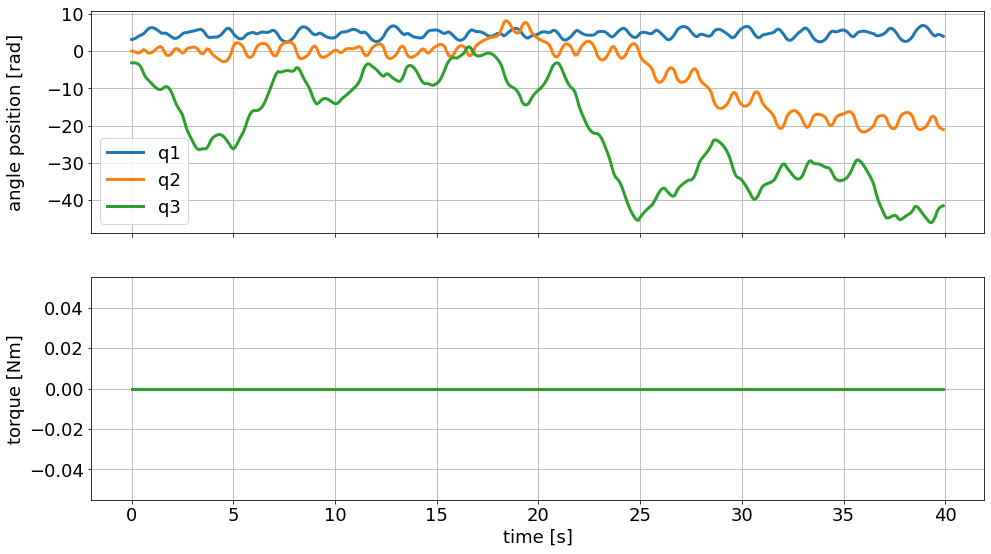

In [15]:
# Running the simulation

u0 = np.zeros((3,1))
for i in range(400):
    simulator.make_step(u0)

sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    92346
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    46014

Total number of variables............................:    22518
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    11907
                     variables with only upper bounds:        0
Total number of equa

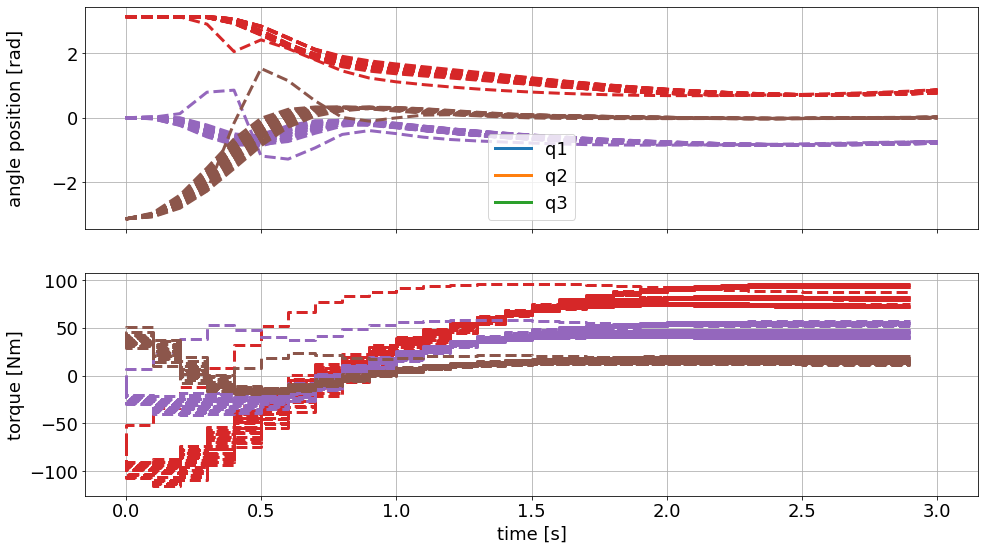

In [16]:
# Running the optimizer

u0 = mpc.make_step(x0)

sim_graphics.clear()

mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
#mpc_graphics.reset_legend()
# Show the figure:
fig

In [17]:
# Change the color for the three states:
for line_i in mpc_graphics.pred_lines['_x', 'q1']: line_i.set_color('#1f77b4') # blue
for line_i in mpc_graphics.pred_lines['_x', 'q2']: line_i.set_color('#ff7f0e') # orange
for line_i in mpc_graphics.pred_lines['_x', 'q3']: line_i.set_color('#2ca02c') # green
# Change the color for the two inputs:
for line_i in mpc_graphics.pred_lines['_u', 'u1']: line_i.set_color('#1f77b4')
for line_i in mpc_graphics.pred_lines['_u', 'u2']: line_i.set_color('#ff7f0e')
for line_i in mpc_graphics.pred_lines['_u', 'u3']: line_i.set_color('#2ca02c')

# Make all predictions transparent:
for line_i in mpc_graphics.pred_lines.full: line_i.set_alpha(0.2)

In [18]:
# Get line objects (note sum of lists creates a concatenated list)
lines = sim_graphics.result_lines['_x', 'q1']+sim_graphics.result_lines['_x', 'q2']+sim_graphics.result_lines['_x', 'q3']

ax[0].legend(lines,'123',title='disc')

# also set legend for second subplot:
lines = sim_graphics.result_lines['_u', 'u1']+sim_graphics.result_lines['_u', 'u2']+sim_graphics.result_lines['_u', 'u3']
ax[1].legend(lines,'12',title='motor')

In [19]:
# running the control loop

simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [20]:
%%capture
for i in range(60):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

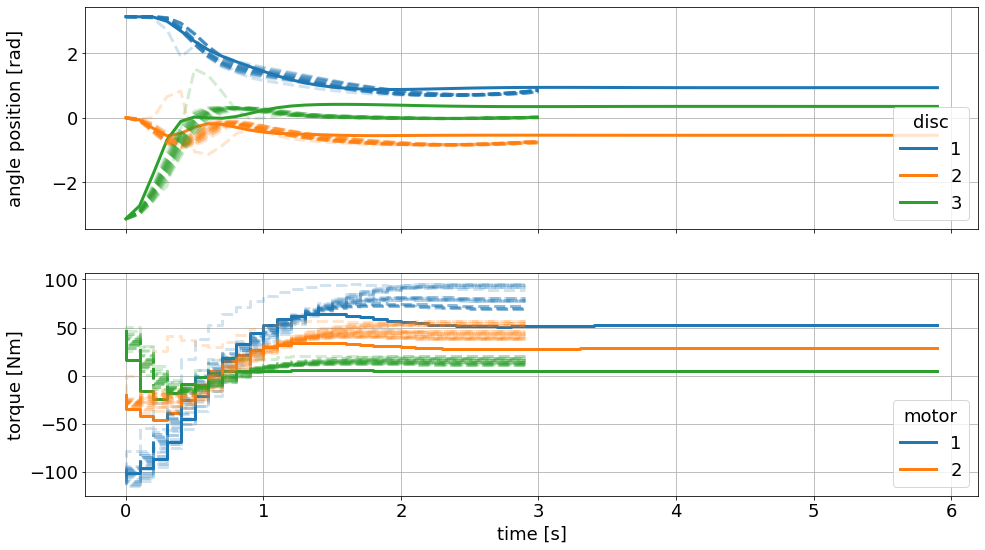

In [21]:
# Plot predictions from t=0
mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig

In [22]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

def update(t_ind):
    sim_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()


In [23]:
anim = FuncAnimation(fig, update, frames=60, repeat=False)
gif_writer = ImageMagickWriter(fps=3)
anim.save('anim.gif', writer=gif_writer)